## 1-Parameter Estimation
Parameter estimation following this [tutorial](https://docs.sciml.ai/DiffEqParamEstim/stable/getting_started/) using symbolic packages

In [140]:
using Pkg
Pkg.activate("../../PINN")

using DifferentialEquations, RecursiveArrayTools, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO
using Plots
using ModelingToolkit

  Activating project at `~/SURE2023/scientific_julia/jen`


In [141]:
@parameters t p
@variables x(t) y(t) z(t)
Dt = Differential(t)

# ode system with parameter p
f = [Dt(x) ~ -x + p*z,  # dx/dt = -x + 3z
    Dt(y) ~ -y + 2*z,  # dy/dt = -y + 2z
    Dt(z) ~ x^2 - 2*z] # dz/dt = x^2 - 2z

3-element Vector{Equation}:
 Differential(t)(x(t)) ~ p*z(t) - x(t)
 Differential(t)(y(t)) ~ 2z(t) - y(t)
 Differential(t)(z(t)) ~ x(t)^2 - 2z(t)

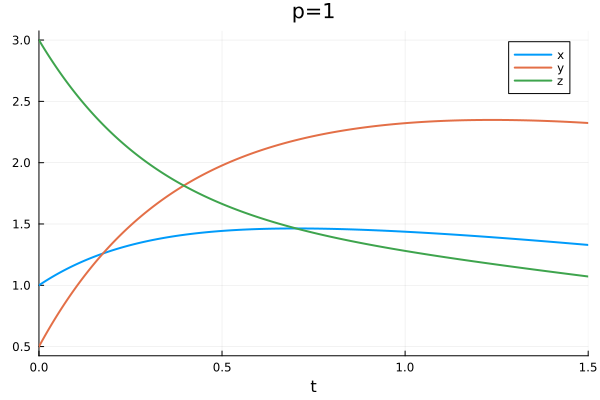

In [142]:
# first we solve the system with a unique parameter value, ps
# parameter space
@named odesystem = ODESystem(f)

# initial conditions
u0 = [x => 1, y => 1/2, z =>3]
ps = [p => 1]

# timespan
tspan = (0.0,1.5)

prob = ODEProblem(odesystem, u0, tspan, ps)
sol = solve(prob,Tsit5())
# visualize the solution
plot(sol, linewidth=2, label=["x" "y" "z"], title="p=1", xlabel="t")


In [143]:
# we generate synthetic data using this solution (p value above)
t = collect(range(0,stop=1.5,length=200))
randomized = VectorOfArray([(sol(t[i]) + .01randn(3)) for i in eachindex(t)])
data = convert(Array,randomized)

3×200 Matrix{Float64}:
 1.00644   1.01079   1.01976   …  1.33364  1.31448  1.32452  1.32264
 0.513318  0.530454  0.579579     2.34652  2.34688  2.33102  2.3184
 3.00095   2.9524    2.92634      1.08115  1.05596  1.07794  1.07805

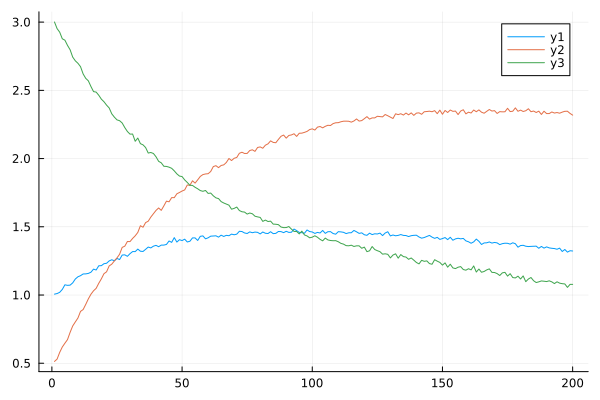

In [144]:
# Visualizing synthetic data
plot(data[1, :])
plot!(data[2, :])
plot!(data[3, :])

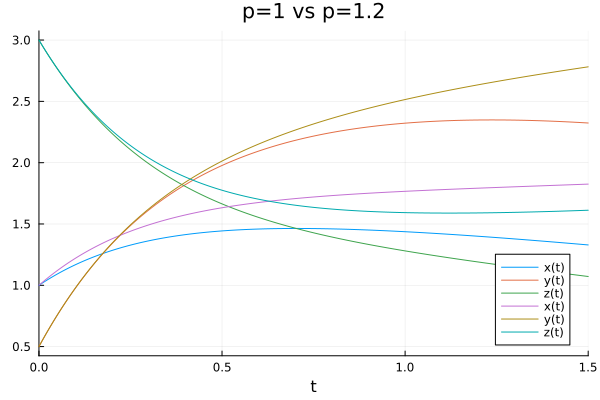

In [145]:
# redefine the prob with a new parameter
newprob = remake(prob, p=1.2)
newsol = solve(newprob,Tsit5())
# visualize the two solutions together
plot(sol, title="p=1 vs p=1.2")
plot!(newsol)

`build_loss_objective` builds an objective function to be used with Optim.jl

`function build_loss_objective`

            (prob::DEProblem, alg, loss,
                                    adtype = SciMLBase.NoAD(),
                                    regularization = nothing;
                                    priors = nothing,
                                    prob_generator = STANDARD_PROB_GENERATOR,
                                    kwargs...)

- First argument is the `DEProblem` to solve
- Next is the algorithm to use, which must match the problem type
- `regularization` defaults to nothing

Internally, this objective function is calling the ODE solver to get solutions to test against the data.

- `maxiters` is set in a way that causes the DE solvers to error more quickly when in bad regions of the parameter space (speeds up the process)
    - if the integrator stops early, given infinite loss
- `verbose=false` because this can get noisy
- `Optimization.AutoForwardDIff()` is a choice of automatic differentiation (how gradients are calculated)

In [146]:
# define an objective (cost) function for optimization
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t,data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters=10000,verbose=false)


(::OptimizationFunction{true, Optimization.AutoForwardDiff{nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#522"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x7d0f69a6, 0xcd3f52a8, 0xbaddc4ab, 0xcf680593, 0x99dce2c5), Expr}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x05460bb1, 0xe88addd2, 0xf9e66953, 0x99603b5a, 0x968746d7), Expr}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Symbol, V

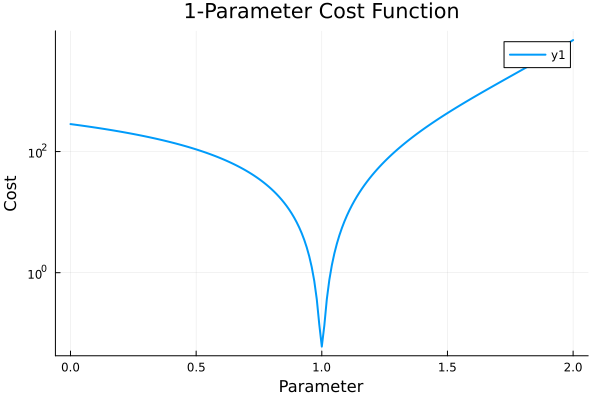

In [147]:
# test the parameter space [0,2] with the cost_function
param_space = 0.0:0.01:2
cost = [cost_function(i) for i in param_space]
# visualize the 
plot(param_space, cost, yscale=:log10, xlabel="Parameter",
     ylabel="Cost", title="1-Parameter Cost Function", lw=2)

Well-defined minimum in the cost function at the real parameter, which we set to be `ps=1`.

Can now use the `BFGS` algorithm to optimize the parameter starting at `p=1.2`. We do this by creating an optimization problem and solving that with `BFGS()`.

In [148]:
optprob = Optimization.OptimizationProblem(cost_function, [1.2])
optsol = solve(optprob, BFGS())

u: 1-element Vector{Float64}:
 1.0002517332202638

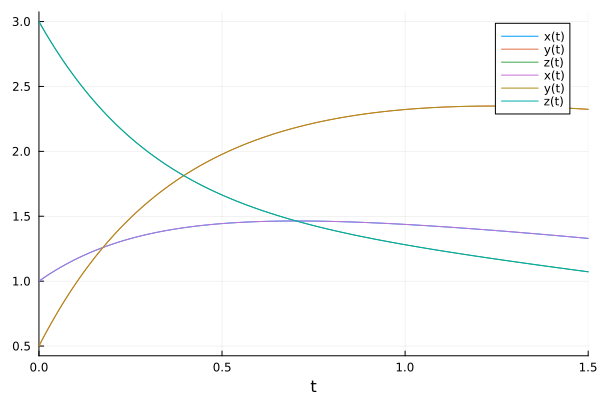

In [149]:
# Visualizing performance
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5())
plot(sol)
plot!(newsol)

## Multiple Parameter Estimation
All parameters free.

In [175]:
# Defining new ODE system
@parameters p[1:6]
@variables t x(t) y(t) z(t)
Dt = Differential(t)

# ode system with parameter p
f = [Dt(x) ~ p[1]*x + p[2]*z,  # dx/dt = -x + z
    Dt(y) ~ p[3]*y + p[4]*z,  # dy/dt = -y + 2z
    Dt(z) ~ p[5]*x^2 + p[6]*z] # dz/dt = x^2 - 2z

@register f(x, y, z, t)

# first we solve the system with a unique parameter value, ps
# parameter space
@named odesystem = ODESystem(f)

# initial conditions
u0 = [x => 1, y => 1/2, z => 3]
ps = [-1, 1, -1, 2, 1, -2]

# timespan
tspan = (0.0,1.5)

prob = ODEProblem(odesystem, u0, tspan, ps)
sol = solve(prob,Tsit5())
# visualize the solution
plot(sol, linewidth=2, label=["x" "y" "z"], title="p=1", xlabel="t")

ErrorException: cannot define function f; it already has a value

In [172]:
# Building objective function
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data), 
                                    Optimization.AutoForwardDiff(),
                                    maxiters=10000, verbose=false)
optprob = Optimization.OptimizationProblem(cost_function, [-0.9,0.8,-1.3,1.6,1.3,-1.6])
sol = solve(optprob, BFGS())

TypeError: TypeError: non-boolean (Num) used in boolean context

In [152]:
# Visualizing performance
newprob = remake(prob, p = sol.u)
newsol = solve(newprob, Tsit5())
plot(newsol)

MethodError: MethodError: Cannot `convert` an object of type Vector{Float64} to an object of type Float64
Closest candidates are:
  convert(::Type{T}, !Matched::Union{Static.StaticBool{N}, Static.StaticFloat64{N}, Static.StaticInt{N}} where N) where T<:Number at ~/.julia/packages/Static/s64Zx/src/Static.jl:414
  convert(::Type{<:Number}, !Matched::SciMLOperators.ComposedScalarOperator) at ~/.julia/packages/SciMLOperators/sAAp1/src/scalar.jl:234
  convert(::Type{T}, !Matched::ChainRulesCore.AbstractZero) where T<:Number at ~/.julia/packages/ChainRulesCore/0t04l/src/tangent_types/abstract_zero.jl:31
  ...

However, this method is sensitive and depends on the initial guess.